## **Moving Averages**

In [1]:
import pandas as pd

In [2]:
weather = pd.read_csv('Data/madrid_weather.csv', parse_dates=['time'])
weather.head()

C:\Users\Camilo\AppData\Local\Temp\ipykernel_15596\619251572.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather = pd.read_csv('Data/madrid_weather.csv', parse_dates=['time'])


,time,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
0,2019-01-01 00:59:00,3.1,0.65,64,50,949,0,0.0
1,2019-01-01 01:59:00,2.9,0.95,32,49,949,0,0.0
2,2019-01-01 02:59:00,3.1,0.87,62,46,949,0,0.0
3,2019-01-01 03:59:00,1.9,0.73,75,51,949,0,0.0
4,2019-01-01 04:59:00,0.7,0.57,53,56,949,0,0.0


<Axes: xlabel='time'>

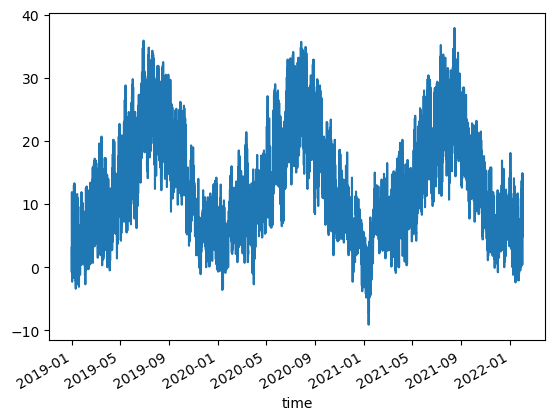

In [3]:
weather.set_index('time').loc[:, 'temperature'].plot()

<Axes: xlabel='time'>

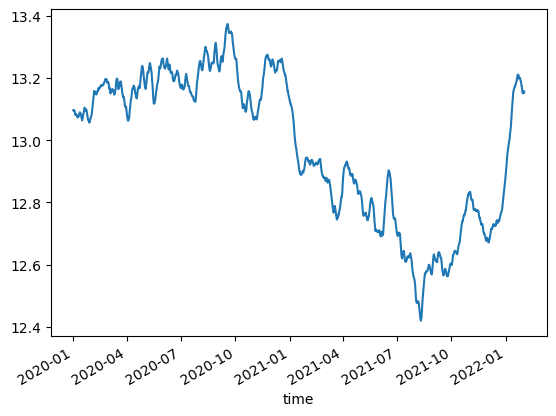

In [4]:
#  24 = daily moving average
# (24 * 30) = 30-day moving average
# (24 * 365) = yearly moving average

weather.set_index('time').loc[:, 'temperature'].rolling((24 * 365)).mean().plot()

## **Decomposition**

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

taco_stands = pd.read_csv('Data/taco_stands.csv', parse_dates=['Date'])
taco_stands.head()

C:\Users\Camilo\AppData\Local\Temp\ipykernel_15596\3883197694.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  taco_stands = pd.read_csv('Data/taco_stands.csv', parse_dates=['Date'])


,Date,Taco Stands in LA
0,2010-01-01,12
1,2010-02-01,15
2,2010-03-01,15
3,2010-04-01,19
4,2010-05-01,24


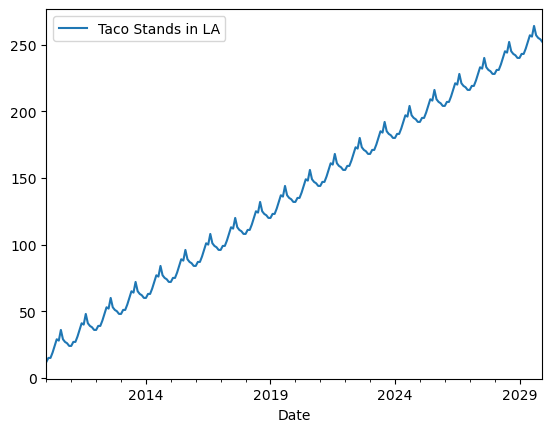

In [6]:
taco_stands.set_index('Date').plot();

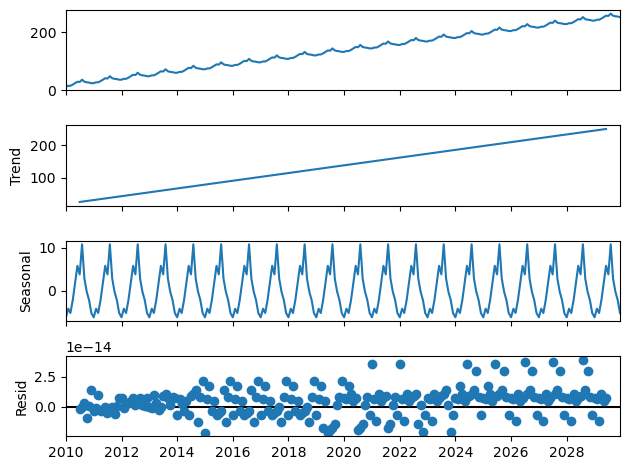

In [7]:
seasonal_decompose(taco_stands.set_index('Date')).plot();

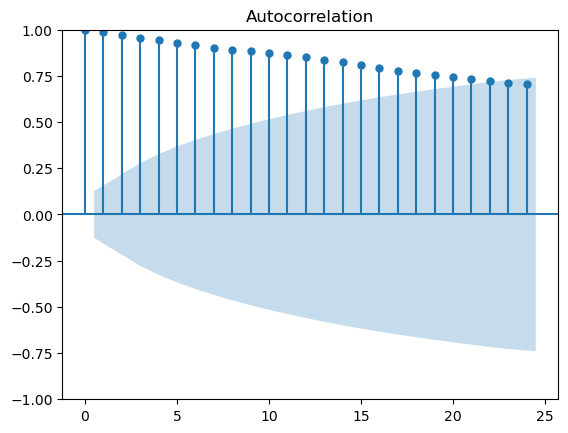

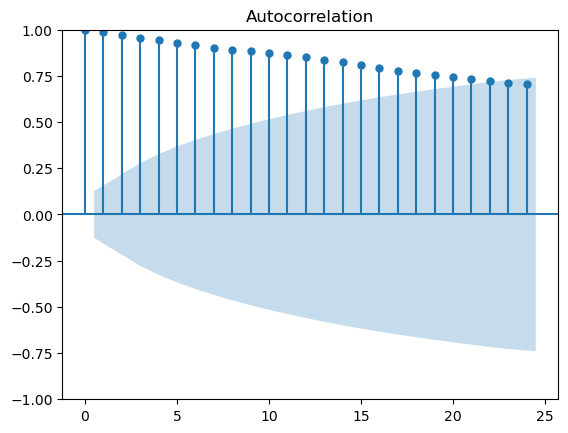

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(taco_stands.set_index('Date'))

## **Linear Regression**

In [9]:
monthly_weather = (
    weather
    .set_index('time')
    .resample('ME')
    .agg({'temperature': 'mean'})
    .reset_index()
)

#monthly_weather = weather.set_index('time').resample('ns').agg({'temperature':'mean'}).reset_index()
monthly_weather.head()

,time,temperature
0,2019-01-31,4.267473
1,2019-02-28,6.645982
2,2019-03-31,9.244489
3,2019-04-30,9.032222
4,2019-05-31,15.345968


In [10]:
monthly_weather = monthly_weather.assign(
    trend = monthly_weather.index,
    month = monthly_weather['time'].dt.month.astype('object')
)

monthly_weather.head()

,time,temperature,trend,month
0,2019-01-31,4.267473,0,1
1,2019-02-28,6.645982,1,2
2,2019-03-31,9.244489,2,3
3,2019-04-30,9.032222,3,4
4,2019-05-31,15.345968,4,5


In [13]:
monthly_weather = pd.get_dummies(monthly_weather, drop_first=True)

monthly_weather[monthly_weather.select_dtypes(bool).columns] = (
    monthly_weather.select_dtypes(bool).astype(int)
)

monthly_weather.tail()

,time,temperature,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
32,2021-09-30,17.679583,32,0,0,0,0,0,0,0,1,0,0,0
33,2021-10-31,13.863306,33,0,0,0,0,0,0,0,0,1,0,0
34,2021-11-30,6.686667,34,0,0,0,0,0,0,0,0,0,1,0
35,2021-12-31,6.859140,35,0,0,0,0,0,0,0,0,0,0,1
36,2022-01-31,5.027500,36,0,0,0,0,0,0,0,0,0,0,0


In [16]:
weather_train = monthly_weather.set_index('time').loc[:'2021-09']
weather_test = monthly_weather.set_index('time').loc['2021-10-31':]

weather_test

,temperature,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,
2021-10-31,13.863306,33,0,0,0,0,0,0,0,0,1,0,0
2021-11-30,6.686667,34,0,0,0,0,0,0,0,0,0,1,0
2021-12-31,6.859140,35,0,0,0,0,0,0,0,0,0,0,1
2022-01-31,5.027500,36,0,0,0,0,0,0,0,0,0,0,0


In [17]:
import statsmodels.api as sm

y = weather_train['temperature']
X = sm.add_constant(weather_train.iloc[:, 1:]) #.drop('trend', axis=1)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     173.9
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           1.71e-17
Time:                        15:39:24   Log-Likelihood:                -34.161
No. Observations:                  33   AIC:                             94.32
Df Residuals:                      20   BIC:                             113.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7023      0.543      6.821      0.000       2.570       4.834
trend         -0.0202      0.017     -1.224      0.235      -0.055       0.014
month_2        3.8329      0.715      5.363      0.000       2.342       5.324
month_3        5.0075      0.715      7.000      0.000       3.515       6.500
month_4        6.3682      0.716      8.891      0.000       4.874       7.862
month_5       12.2588      0.718     17.083      0.000      10.762      13.756
month_6       16.4488      0.719     22.867      0.000      14.948      17.949
month_7       21.0890      0.721     29.234      0.000      19.584      22.594
month_8       20.1080      0.724     27.779      0.000      18.598      21.618
month_9       14.6140      0.727     20.111      0.000      13.098      16.130
month_10       8.9681      0.800     11.204      0.000       7.298      10.638
month_11       4.1758      0.802      5.209      0.000       2.504       5.848
month_12       1.7290      0.803      2.153      0.044       0.054       3.404
==============================================================================
Omnibus:                        5.381   Durbin-Watson:                   2.678
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                1.866
Skew:                          -0.050   Prob(JB):                        0.393
Kurtosis:                       1.839   Cond. No.                         224.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
y_test = weather_test['temperature']
X_test = sm.add_constant(weather_test.iloc[:, 1:])

prediction = model.predict(X_test)
prediction

time
2021-10-31    12.003094
2021-11-30     7.190608
2021-12-31     4.723525
2022-01-31     2.974332
dtype: float64

In [20]:
pred_df = pd.DataFrame({'actual': y_test, 'predicted':prediction})
pred_df

,actual,predicted
time,,
2021-10-31,13.863306,12.003094
2021-11-30,6.686667,7.190608
2021-12-31,6.859140,4.723525
2022-01-31,5.027500,2.974332


In [21]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

print(mape(pred_df['actual'], pred_df['predicted']))
print(mae(pred_df['actual'], pred_df['predicted']))

0.23232204465716122
1.6382340921105074


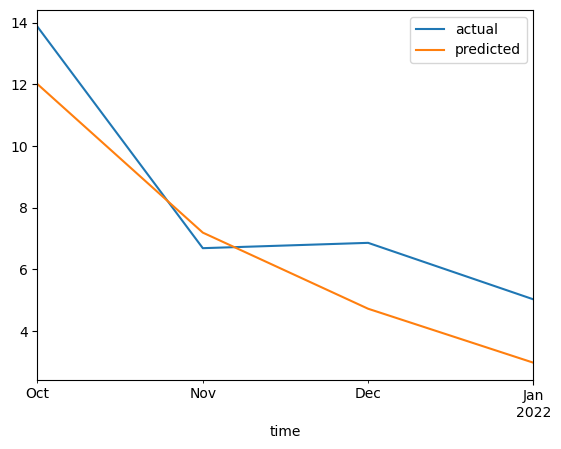

In [23]:
pred_df.plot();